# Salpeter & Friends

Sample N stars from Salpeter, Kroupa and Chabrier initial mass function using rejection sampling or inverse transform sampling.

- Salpeter IMF (1955)
$$
\xi(m) \propto m^{-\alpha}, \quad \alpha = 2.35 \quad \text{for } m \geq 0.1\,M_\odot
$$

- Kroupa IMF (2001)
$$
\xi(m) \propto 
\begin{cases}
m^{-0.3}, & 0.01 < m \leq 0.08\,M_\odot \\
m^{-1.3}, & 0.08 < m \leq 0.5\,M_\odot \\
m^{-2.3}, & m > 0.5\,M_\odot
\end{cases}
$$

- Chabrier IMF (2003)
$$
\xi(m) \propto 
\begin{cases}
\exp\left[ -\frac{(\log_{10} m - \log_{10} 0.22)^2}{2 \cdot 0.57^2} \right], & m \leq 1\,M_\odot \\
m^{-2.3}, & m > 1\,M_\odot
\end{cases}
$$

## Sampling from a Known Distribution

There are several standard techniques to generate random samples from a known probability distribution.


### 1. Using Built-in Functions

If the distribution is standard (e.g., Gaussian, exponential, uniform), use built-in routines:

```python
x = np.random.normal(loc=0, scale=1, size=1000)  # Normal(0,1)
x = np.random.exponential(scale=1.0, size=1000)  # Exponential(λ = 1)
```


### 2. Inverse Transform Sampling

If a distribution has a known cumulative distribution function $F(x)$, and we can compute its inverse $F^{-1}(u)$, then:

$$
x = F^{-1}(u), \quad \text{where } u \sim \text{Uniform}(0, 1)
$$

This works because the CDF maps the distribution into a uniform variable, and the inverse maps it back into the desired distribution.


### 3. Rejection Sampling

Used when the distribution $f(x)$ is known but we can't invert its CDF.

Steps:

1. Choose a proposal distribution $g(x)$ that's easy to sample from.
2. Find a constant $M$ such that:

$$
f(x) \leq M \cdot g(x) \quad \text{for all } x
$$

3. Repeat:
   - Sample $x \sim g(x)$
   - Sample $u \sim \text{Uniform}(0, 1)$
   - Accept $x$ if $u < \frac{f(x)}{M g(x)}$

This gives samples approximately from $f(x)$.



In [98]:
import numpy as np
import matplotlib.pyplot as plt
#import random

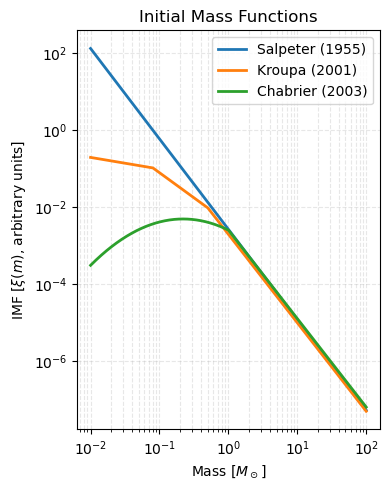

In [100]:
def salpeter_imf(m, alpha=2.35): # m in [0.01,100]
    normalization = 1/(-alpha+1) * (1e2**(-alpha+1) -1e-2**(-alpha+1))
    return m**(-alpha) / normalization

def kroupa_imf(m):
    m = np.atleast_1d(m)
    imf = np.zeros_like(m)

    # Normalization constants to ensure continuity
    A = 0.05 #1.0                         # arbitrary normalization (IT STAYS UNDERV )
    B = A * (0.08**-0.3) / (0.08**-1.3)
    C = B * (0.5**-1.3) / (0.5**-2.3)

    # Piecewise definition
    imf[m < 0.08] = A * m[m < 0.08]**-0.3
    imf[(m >= 0.08) & (m < 0.5)] = B * m[(m >= 0.08) & (m < 0.5)]**-1.3
    imf[m >= 0.5] = C * m[m >= 0.5]**-2.3

    return imf


def chabrier_imf(m):
    m = np.atleast_1d(m)
    imf = np.zeros_like(m)

    # Parameters from Chabrier (2003)
    m0 = 0.22
    sigma = 0.57
    log10m0 = np.log10(m0)

    # Log-normal part for m <= 1
    mask1 = m <= 1
    logm = np.log10(m[mask1])
    A = 0.005 #0.158  # arbitrary normalization

    imf[mask1] = A * np.exp(-(logm - log10m0)**2 / (2 * sigma**2))

    # Power-law part for m > 1
    mask2 = m > 1
    B = A * np.exp(-(np.log10(1) - log10m0)**2 / (2 * sigma**2)) / (1**-2.3)  # continuity
    imf[mask2] = B * m[mask2]**-2.3

    return imf


# Mass range
m = np.logspace(-2, 2, 1000)  # from 0.01 to 100 solar masses

# Plotting
fig, ax = plt.subplots(figsize=(4, 5))

ax.plot(m, salpeter_imf(m), label="Salpeter (1955)", lw=2)
ax.plot(m, kroupa_imf(m), label="Kroupa (2001)", lw=2)
ax.plot(m, chabrier_imf(m), label="Chabrier (2003)", lw=2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mass [$M_\\odot$]")
ax.set_ylabel("IMF [$\\xi(m)$, arbitrary units]")
ax.set_title("Initial Mass Functions")
ax.legend()
ax.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()

In [101]:
# analytic distribution function, easily integrable and invertible
def inverse_integral_salpeter(F,alpha=2.35):
    # F is the normalized integral and ranges in [0,1]
    normalization = 1/(alpha-1) * 0.1 ** -(alpha-1)
    m = ( 0.1** - (alpha-1) - 1.35*normalization*F)**(-1/(alpha-1))
    return m

def salpeter_inverse_sampler(N):
    F = np.random.rand(N)  
    m = inverse_integral_salpeter(F)
    return m

In [102]:
# Rejection sampling for Kroupa and Chabrier IMF
def imf_rejection_sampler(N,imf):

    sample = []
    while len(sample) < N:
        # sample from Salpeter
        m = salpeter_inverse_sampler(1)[0]
        f_m = imf(m)
        u = np.random.rand()
        if u < f_m / salpeter_imf(m):
            sample.append(m)

    return sample



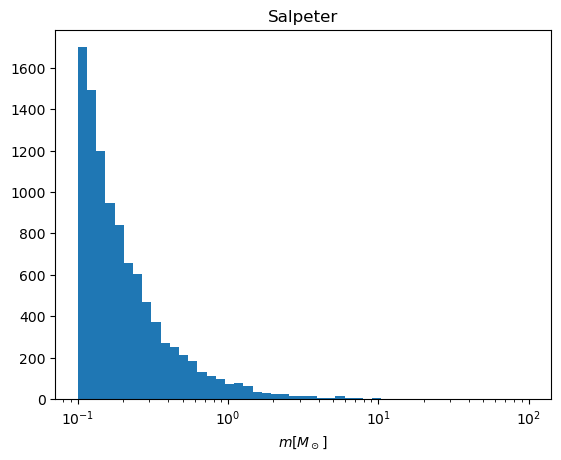

In [110]:

m = salpeter_inverse_sampler(10000)

plt.hist(m,bins=np.logspace(-1,2,50))

plt.xscale('log')

plt.title('Salpeter')
plt.xlabel('$m [M_\odot]$')
plt.show()


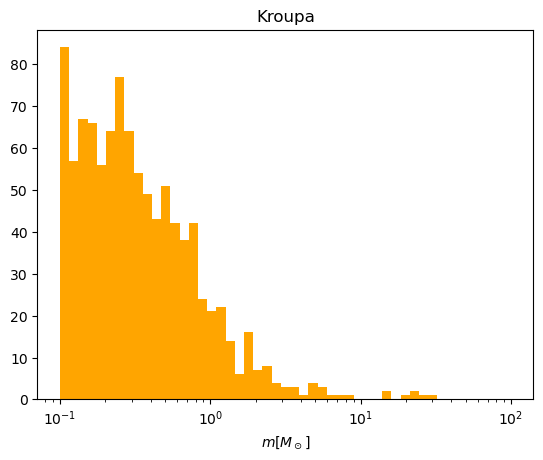

In [114]:
m = imf_rejection_sampler(1000,kroupa_imf)
plt.hist(m,bins=np.logspace(-1,2,50),color='orange')
plt.xscale('log')

plt.title('Kroupa')
plt.xlabel('$m [M_\odot]$')
plt.show()


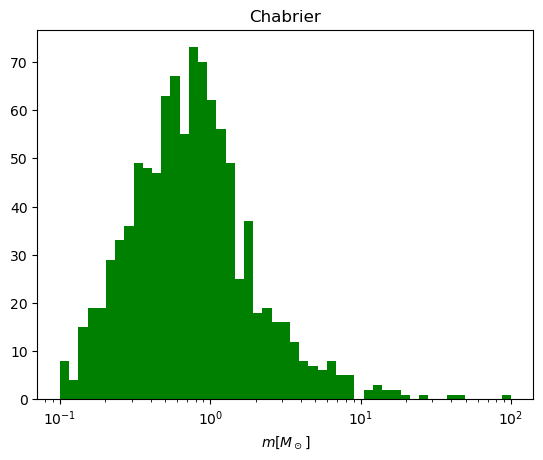

In [115]:
m = imf_rejection_sampler(1000,chabrier_imf)
plt.hist(m,bins=np.logspace(-1,2,50),color='green')
plt.xscale('log')

plt.title('Chabrier')
plt.xlabel('$m [M_\odot]$')
plt.show()
